In [ ]:
# ! pip3 install wavio 
# ! pip3 install librosa
# ! pip3 install sounddevice 
#! pip3 install --force-reinstall matplotlib==3.7.0
# ! pip3 install setuptools

In [2]:
# import necessary modules
import sounddevice as sd
from scipy.io.wavfile import write
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fftshift
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.signal import square, ShortTimeFFT
from scipy.signal.windows import gaussian
import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import IPython.display as ipd

In [2]:
# Define Sampling Rate or Frequency in Hz
sr = 44100

# Record duration in seconds
duration = 5

# Start audio recording
recording = sd.rec(int(duration*sr), samplerate=sr, channels=2) # we will record with a  mono or stereo channel microphone

# Record audio for the given duration
print("recording...............")
sd.wait()

# Write it to a file
write("phrase.wav",sr,recording)

recording...............


In [84]:
# Look at the discrete number array we got from the audio
x, sr = librosa.load('teamSpencer-speedchirp.wav')
print("recording shape", x.shape)
print("sampling rate", sr)

recording shape (110250,)
sampling rate 22050


Text(126.09722222222221, 0.5, 'amplitude')

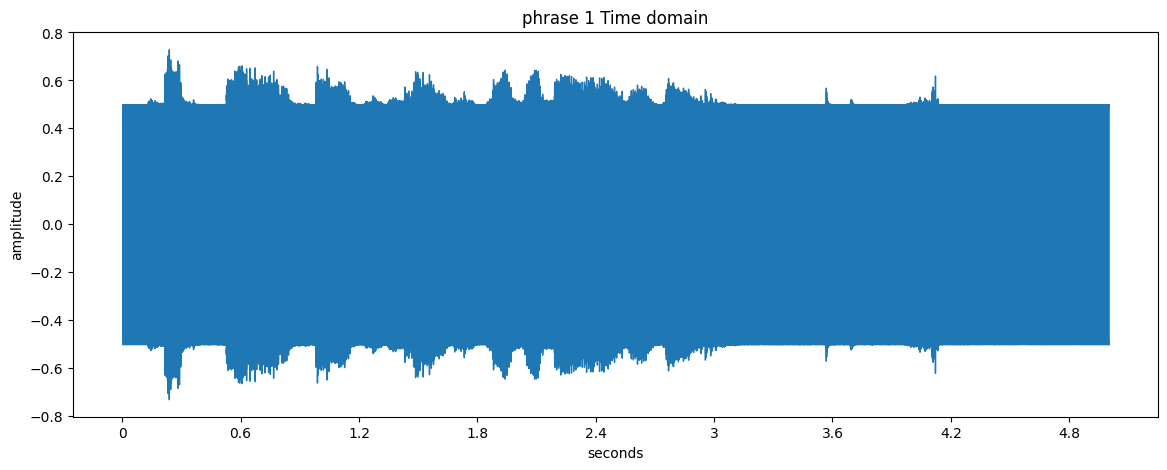

In [85]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('phrase 1 Time domain')
plt.xlabel('seconds')
plt.ylabel('amplitude')

(220000,)
44000
(1025, 430)


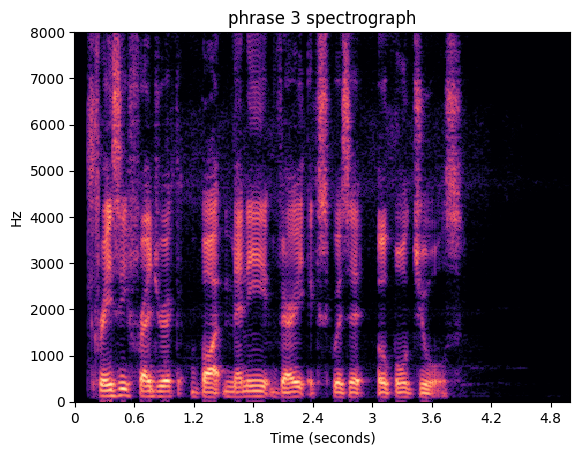

In [125]:
#spectrogram
data, sampling_rate = librosa.load("phrase_3.wav", sr = 44000)
print(data.shape)
print(sampling_rate)

freq = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
print(freq.shape)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.set_ylim(ymax=8000)
plt.title('phrase 3 spectrograph')
librosa.display.specshow(freq, y_axis='linear', x_axis='s',sr=sampling_rate,ax=ax)



In [136]:
def apply_sound_delay(wav_file, delay_samples, output_file=None):
    data, sr = librosa.load(wav_file)

    # Ensure stereo signal
    if data.ndim == 1:
        data = np.tile(data, (2, 1))

    # Apply delay to the second channel
    delayed_channel = np.roll(data[0], delay_samples)
    delayed_signal = np.stack((data[1], delayed_channel), axis=0)

    # Save the result (using librosa for consistency)
    if output_file:
        sf.write(output_file, delayed_signal.T, sr)
    else:
        sf.write(wav_file, delayed_signal.T, sr)  # Overwrite original

In [147]:
delay_ms = 100 # Delay in milliseconds
delay_samples = int(44100 * (delay_ms / 1000)) 

apply_sound_delay('phrase_2.wav', delay_samples, 'teamSpencer-sterosoundfile-100.wav')

In [130]:
def attenuate_right_channel(input_file, output_file, db_attenuation):
    # Load the audio data and sample rate
    data, sr = librosa.load(input_file, mono=False)  # Load as stereo

    if data.ndim == 1:
        data = np.tile(data, (2, 1))

    # Convert dB attenuation to a linear gain factor
    gain_factor = 10 ** (-db_attenuation / 20)

    # Apply attenuation to the right channel
    data[:1] *= gain_factor 

    # Save the modified audio data to a new WAV file (using soundfile)
    sf.write(output_file, data.T, sr)  # Transpose for correct stereo format

In [150]:
# Example usage (remains the same)
input_file = 'phrase_2.wav'
output_file = 'teamSpencer-sterosoundfile-0-20.wav'
attenuation_db = -20 # Attenuate by 3 dB
attenuate_right_channel(input_file, output_file, attenuation_db)

Above this markdown is the project 1 code. Below it is everything that I am adding for project 2. Because so much of the code is the same I'm doing it in one file. 

In [5]:
#question 1: generate 
# Parameters
frequency = 5000  # Hz
sr = 44100  # Hz
duration = 5  # seconds

# Generate time array
t = np.linspace(0, duration, sr * duration, endpoint=False)

# Calculate the sine wave
waveform = np.sin(2 * np.pi * frequency * t)

# Scale to appropriate amplitude for audio
waveform *= 32767  # Assuming 16-bit audio
waveform = waveform.astype(np.int16)

# Save audio to a WAV file using SoundFile
sf.write("sine_tone.wav", waveform, sr)

(1025, 430)


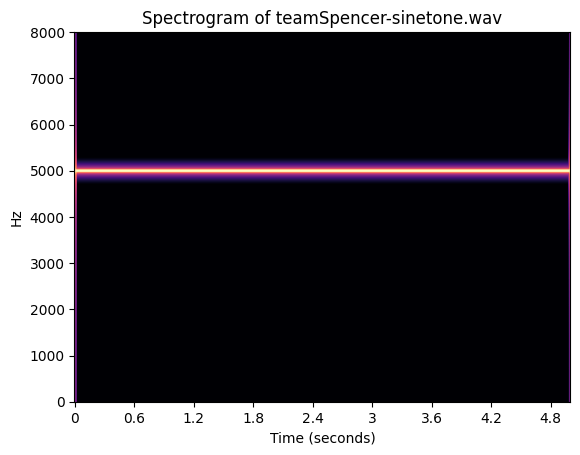

In [86]:
# I rewrote my spectrogram generation using a function so I can apply it better elsewhere
def spectrogram(filename, sample_rate=44000):
    data, sampling_rate = librosa.load(filename, sr=sample_rate)

    freq = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    print(freq.shape)

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    ax.set_ylim(ymax=8000)
    plt.title('Spectrogram of ' + filename)  
    librosa.display.specshow(freq, y_axis='linear', x_axis='s', sr=sampling_rate, ax=ax)
    plt.show()  # Display the plot

# Example usage
spectrogram("teamSpencer-sinetone.wav")  

In [8]:
#chirp signal generation
start_freq = 0        # Starting frequency (Hz)
end_freq = 8000       # Ending frequency (Hz)
sample_rate = 44100   # Sampling rate (Hz)
duration = 5          # Duration (seconds)

# Generate time array
time_array = np.linspace(0, duration, sample_rate * duration, endpoint=False)

# Calculate the instantaneous phase for the chirp
phase = start_freq * time_array + (end_freq - start_freq) * time_array**2 / (2 * duration)

# Generate the chirp waveform
chirp_waveform = np.sin(2 * np.pi * phase)

# Scale to appropriate amplitude
chirp_waveform *= 32767 
chirp_waveform = chirp_waveform.astype(np.int16)

# Save the chirp to a WAV file
sf.write("teamSpencer-chirp.wav", chirp_waveform, sample_rate)

(1025, 430)


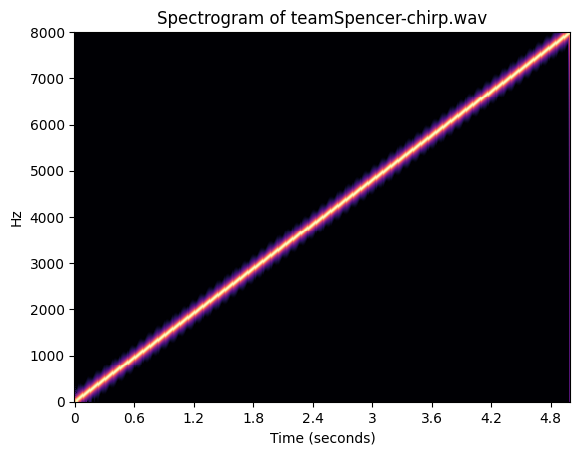

In [9]:
spectrogram("teamSpencer-chirp.wav")

In [20]:
#generating CETK notes
sample_rate = 44100 

# Approximate note frequencies (Hz)
#d6, e6, c6, C7, g6
frequencies = [1174.66, 1318.496, 	1046.496, 523.248,  1300.968]

# Approximate note durations (seconds)
durations = [0.4, 0.6, 1, 0.6, 2] 

# Function to generate a single tone
def generate_tone(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    waveform = np.sin(2 * np.pi * frequency * t)
    return waveform 

# Generate each tone and concatenate
full_sequence = np.concatenate([generate_tone(freq, dur, sample_rate)
                                for freq, dur in zip(frequencies, durations)])

# Add a slight silence between notes
silence = np.zeros(int(sample_rate * 0.1))  # 0.1 second silence
full_sequence = np.concatenate([full_sequence, silence]) 

# Scale and save
full_sequence *= 32767 / np.max(np.abs(full_sequence))
full_sequence = full_sequence.astype(np.int16)
sf.write("teamSpencer-cetk.wav", full_sequence, sample_rate)

(1025, 430)


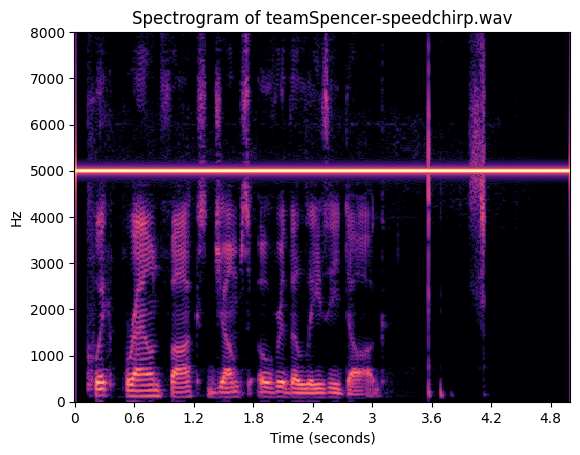

In [24]:
sample_rate = 44100
def mix_wav_files(file1, file2, output_file="mixed.wav"):
    # Load audio data 
    data1, sample_rate = sf.read(file1)
    data2, sample_rate2 = sf.read(file2)

    # If data1 is mono, make it "fake" stereo 
    if data1.ndim == 1:
        data1 = np.tile(data1, (2, 1)).T   

    # If data2 is mono, make it "fake" stereo
    if data2.ndim == 1:
        data2 = np.tile(data2, (2, 1)).T  

    # Mix the audio (simple averaging)
    mixed_data = (data1 + data2) / 2

    # Ensure values aren't clipped
    mixed_data = np.clip(mixed_data, -1.0, 1.0) 

    # Save the mixed audio
    sf.write(output_file, mixed_data, sample_rate)

mix_wav_files("phrase_1.wav", "teamSpencer-sinetone.wav", 'teamSpencer-speedchirp.wav') 
spectrogram('teamSpencer-speedchirp.wav')

In [29]:
def combine_wav_to_stereo(file1, file2, output_file="stereo_output.wav"):
   
    # Load audio data with librosa
    data1, sample_rate1 = librosa.load(file1)
    data2, sample_rate2 = librosa.load(file2)

    # Create stereo signal
    stereo_signal = np.vstack((data1, data2)).T  

    # Save the stereo signal
    sf.write(output_file, stereo_signal, sample_rate1)

# Example usage
combine_wav_to_stereo("phrase_1.wav", "teamSpencer-sinetone.wav", "teamSpencer-sterospeechsine.wav")

In [30]:
def split_stereo_wav(input_file, output_file1="channel1.wav", output_file2="channel2.wav"):

    data, sample_rate = sf.read(input_file)

    # Check if the input is actually stereo
    if data.ndim != 2 or data.shape[1] != 2:
        raise ValueError("Input file is not a stereo WAV file.")

    # Extract the individual channels
    channel1 = data[:, 0]
    channel2 = data[:, 1]

    # Save the channels as separate mono WAV files
    sf.write(output_file1, channel1, sample_rate)
    sf.write(output_file2, channel2, sample_rate)

# Example usage
split_stereo_wav("teamSpencer-sterospeechsine.wav") 


(1025, 430)


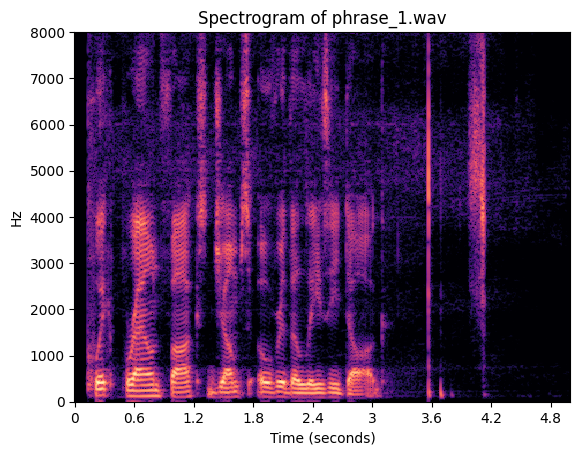

(1025, 430)


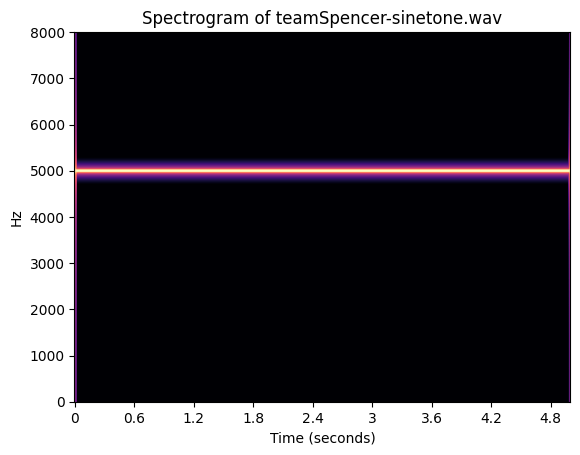

In [32]:
spectrogram('phrase_1.wav')
spectrogram("teamSpencer-sinetone.wav")

Original data shape: (220500,)
Filtered data shape: (220500,)
(1025, 430)


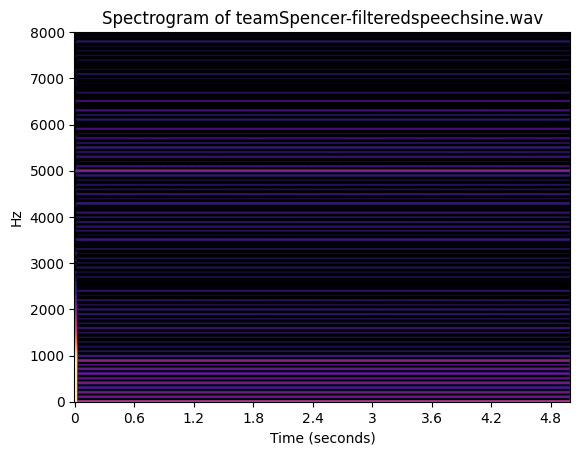

(1025, 430)


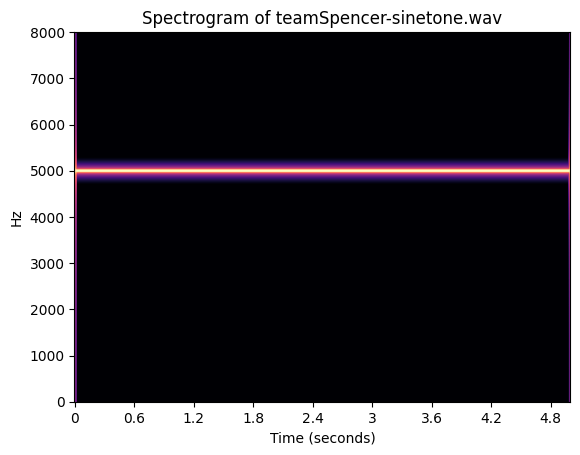

In [196]:
from scipy.signal import butter, lfilter
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, lfilter, freqz
from scipy.signal import butter,sosfilt

def lowpass_filter_wav(input_file, output_file, cutoff_freq=4000, sample_rate=44100, order=8):

    data, samplerate = sf.read(input_file, dtype='float32')

    # Normalize cutoff frequency to Nyquist frequency 
    #nyquist_freq = samplerate
    #normalized_cutoff = cutoff_freq / nyquist_freq

    # Design Butterworth low-pass filter
    sos = signal.butter(order, cutoff_freq, 'lp', analog=False, output='sos', fs=samplerate)

    # Filter the audio data
    filtered_data = sosfilt(sos, data)#, padlen=0)

    # Save the filtered audio
    sf.write(output_file, filtered_data, samplerate)

    print("Original data shape:", data.shape)
    print("Filtered data shape:", filtered_data.shape)

# Example usage
lowpass_filter_wav("teamSpencer-sinetone.wav", "teamSpencer-filteredspeechsine.wav")
spectrogram("teamSpencer-filteredspeechsine.wav")
spectrogram("teamSpencer-sinetone.wav")

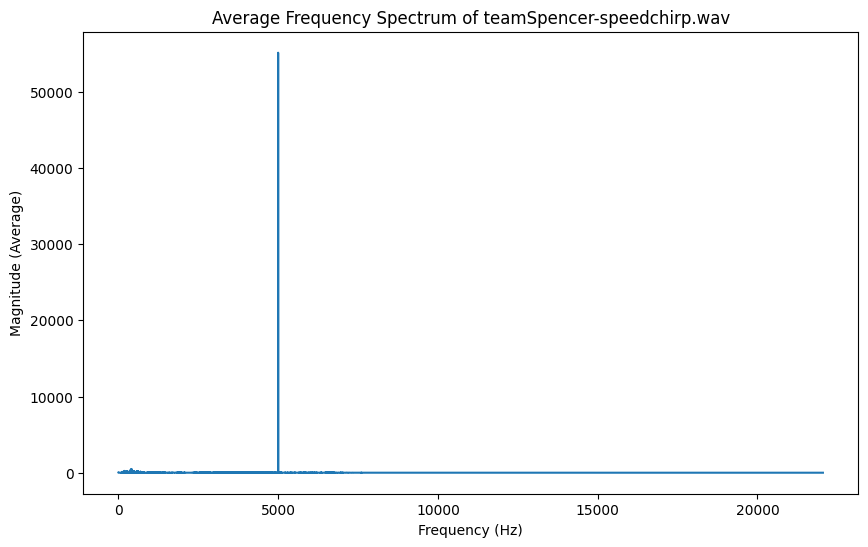

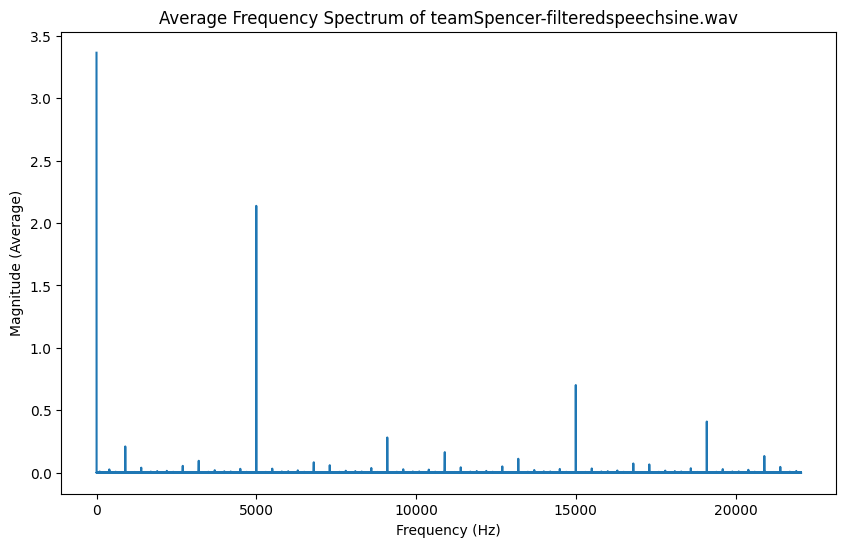

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

def plot_audio_spectrum(filename):
    data, sample_rate = sf.read(filename)

    if data.ndim > 1:  # Check if it's stereo
        data = data.mean(axis=1)  # Average the channels

    # Calculate the FFT (data is now mono)
    fft_spectrum = np.fft.rfft(data)  
    freq = np.fft.rfftfreq(data.size, d=1./sample_rate)  

    # Calculate the magnitude spectrum (no averaging needed)
    magnitude_spectrum = np.abs(fft_spectrum)  

    # Plot the average spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(freq[0:], magnitude_spectrum)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (Average)") 
    plt.title(f"Average Frequency Spectrum of {filename}")
    plt.show()


# Example usage
#plot_audio_spectrum("phrase_1.wav")
#plot_audio_spectrum("teamSpencer-sinetone.wav")
plot_audio_spectrum("teamSpencer-speedchirp.wav")
plot_audio_spectrum("teamSpencer-filteredspeechsine.wav")


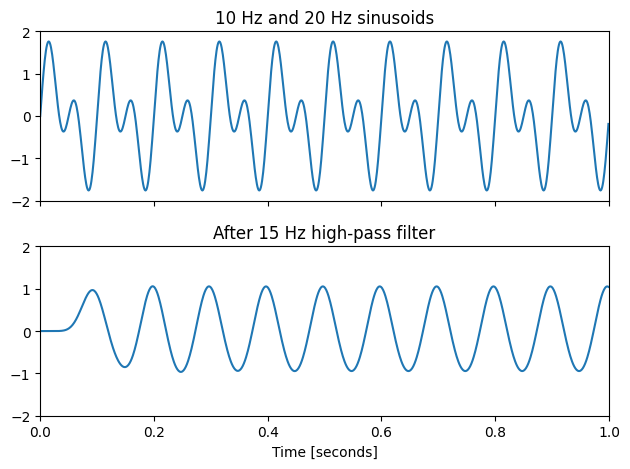

IndexError: tuple index out of range

In [178]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

sos = signal.butter(10, 15, 'lp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()
